In [1]:
import pandas as pd
import re
import string
from textblob import TextBlob
from nltk.tokenize import MWETokenizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('covid_fgli.csv')

In [3]:
#txt preprocessing
schools = ['boston university', 'colby college', 'colorado college', 'columbia university', 'dartmouth college',
          'dickinson college', 'duke university', 'emory university', 'grinnell college', 'hamilton college',
          'kettering university', 'macalester college', 'northeastern oklahoma a&m college', 'pomona college',
          'rice university', 'stanford university', 'university of chicago', 'university of houston', 'university of notre dame',
          'university of pennsylvania', 'university of southern california', 'university of wisconsin-madison', 'vanderbilt university',
          'wellesley college', 'williams college', 'yale university', 'claremont mckenna college' 'usc', 'schools', 
          'brown', 'ucla', 'university', 'college', 'mit', 'harvard', 'tufts university', 'stanford', 'williams',
          'vanderbilt', 'yale', 'grinnell', 'campus', 'northwestern', 'colby', 'columbia', 'duke', 'columbia medical center',
          'macalester', 'dartmouth', 'uw-madison', 'madison', 'hofstra', 'fordham', 'nyu school of law', 'wellesley',
          'babson', 'olin', 'oxford university', 'swarthmore college']
covid_txt = []

for txt in df['Text']:
    txt = txt.strip()
    txt = txt.lower()
    
    if "’s" in txt:
        txt = txt.replace("’s", '')
    
    if 'sars-covid-19' in txt:
        txt = txt.replace('sars-covid-19', 'covid')
    if 'covid-19' in txt:
        txt = txt.replace('covid-19', 'covid')
    if 'coronavirus' in txt:
        txt = txt.replace('coronavirus', 'covid')
    if 'virus' in txt:
        txt = txt.replace('virus', 'covid')
    if 'fli' in txt:
        txt = txt.replace('fli', 'fgli')
    
    for sch in schools:
        if sch in txt:
            txt = txt.replace(sch, 'school')
        else:
            pass
    
    txt = re.sub(r'\.(?! )', '. ', re.sub(r' +', ' ', txt))
    txt = re.sub('\/', ' ', txt)
    txt = re.sub(r'[^\w\s]', '', txt)
    txt = re.sub('\w*\d\w*', '', txt)
    covid_txt.append(txt)

In [4]:
#translates foreign languages in corpus to english
covid_txt[34] = covid_txt[34].replace('siempre pa lante ni un paso pa tras', 'always forward not a step back')

# covid_86 = TextBlob(covid_txt[86])
# covid_txt[86] = str(covid_86.translate(from_lang='ru', to="en"))

# covid_88 = TextBlob(covid_txt[88])
# covid_88 = covid_88.translate(from_lang='vi', to="en")
# covid_txt[88] = str(covid_88.translate(from_lang='zh', to='en'))

#drop documents about russia and vietnam
covid_txt.remove(covid_txt[86])
covid_txt.remove(covid_txt[87])

In [5]:
# from nltk.tokenize import RegexpTokenizer

# for txt in df['Text']:
#     cap_tokenizer = RegexpTokenizer("[A-Z]['\w]+") 
#     print(cap_tokenizer.tokenize(txt))

In [6]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
stop_words_list = ['im', 'ive', 'like', 'dont', 'didnt', 'wasnt', 'said', 'told', 'make', 'going', 'student', 'school',
                  'felt', 'know', 'feel', 'way', 'thing', 'white', 'life', 'office', 'covid', 'able', 'need', 'come',
                   'want', 'started', 'thought', 'got', 'time', 'room', 'away', 'right']

for word in stop_words_list:
    stop_words.add(word)

stemmer = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

asian = ['nonasian', 'asians', 'korea', 'korean', 'japan']
chinese = ['chineseamerican', 'china']
finance = ['financial_aid', 'financial', 'financially', 'financials', 'income', 'lowincome', 'lowerincome', 'low_income',
           'pay', 'paying', 'paycheck', 'paychecktopaycheck', 'payroll', 'payments', 'money']
family = ['mother', 'mom', 'father', 'dad', 'brother', 'sister', 'parent', 'parents']
work = ['working', 'worked']
job = ['workplace', 'workstudy', 'worker', 'coworker']
time = ['day', 'days', 'week', 'weeks', 'year', 'years', 'march']
home = ['house', 'household']

token_txt = []
token_words = [] #for word_count
stem_dict = []

for txt in covid_txt:
    test = word_tokenize(txt)

    filtered_doc = [w for w in test if not w in stop_words]
    filtered_txt = filtered_doc.copy()

    mwe_tokenizer = MWETokenizer([('new', 'mexico'), ('first', 'generation'), ('new', 'jersey'), ('los', 'angeles'), 
                                  ('rise', 'first'), ('astoria', 'queens'), ('coney', 'island'), ('new', 'york'), 
                                  ('new', 'zealand'), ('united', 'states'), ('santa', 'clara'), ('czech', 'republic'), 
                                  ('new', 'orleans'), ('hong', 'kong'), ('world', 'health', 'organization'),
                                  ('financial', 'aid'), ('low', 'income')])
    mwe_tokens = mwe_tokenizer.tokenize(filtered_txt)
    
    
    for word in mwe_tokens:
        if word == 'first_generation':
            i = mwe_tokens.index('first_generation')
            mwe_tokens.insert(i, 'firstgen')
            mwe_tokens.remove('first_generation')
        elif word == 'firstgeneration':
            i = mwe_tokens.index('firstgeneration')
            mwe_tokens.insert(i, 'firstgen')
            mwe_tokens.remove('firstgeneration')
        elif word == 'us':
            i = mwe_tokens.index('us')
            mwe_tokens.insert(i, 'united_states')
            mwe_tokens.remove('us')
        elif word in family:
            i = mwe_tokens.index(word)
            mwe_tokens.insert(i, 'family')
            mwe_tokens.remove(word)
        elif word in work:
            i = mwe_tokens.index(word)
            mwe_tokens.insert(i, 'work')
            mwe_tokens.remove(word)
        elif word in time:
            i = mwe_tokens.index(word)
            mwe_tokens.insert(i, 'time')
            mwe_tokens.remove(word)
        elif word in job:
            i = mwe_tokens.index(word)
            mwe_tokens.insert(i, 'job')
            mwe_tokens.remove(word)
        elif word in finance:
            i = mwe_tokens.index(word)
            mwe_tokens.insert(i, 'finance')
            mwe_tokens.remove(word)
        elif word in asian:
            i = mwe_tokens.index(word)
            mwe_tokens.insert(i, 'asian')
            mwe_tokens.remove(word)
        elif word in chinese:
            i = mwe_tokens.index(word)
            mwe_tokens.insert(i, 'chinese')
            mwe_tokens.remove(word)
        elif word in home:
            i = mwe_tokens.index(word)
            mwe_tokens.insert(i, 'home')
            mwe_tokens.remove(word)
        else:
            pass
    
    orig_words = mwe_tokens.copy()
    stem_dict.append(orig_words)
    
#     for i, word in enumerate(mwe_tokens):
#         mwe_tokens[i] = stemmer.stem(word)
    
    for i, word in enumerate(mwe_tokens):
        mwe_tokens[i] = lemmatizer.lemmatize(word)
        
    mwe_tokens = [w for w in mwe_tokens if not w in stop_words]
    
    token_words.append(mwe_tokens)
    token_txt.append(' '.join(mwe_tokens))

In [7]:
#create a dictionary with original words as values and stemmed words as key
new_dict = []

for li in stem_dict:
    new_dict += li

aux = pd.DataFrame(new_dict, columns =['word'] )
aux['word_stemmed'] = aux['word'].apply(lambda x : stemmer.stem(x))
aux = aux.groupby('word_stemmed').transform(lambda x: ', '.join(x))
aux['word_stemmed'] = aux['word'].apply(lambda x : stemmer.stem(x.split(',')[0]))
aux.index = aux['word_stemmed']
del aux['word_stemmed']
my_dict = aux.to_dict('dict')['word']

In [8]:
df_label = df['Text'].copy()
df_label.drop(df_label.index[86], inplace=True)
df_label.drop(df_label.index[87], inplace=True)

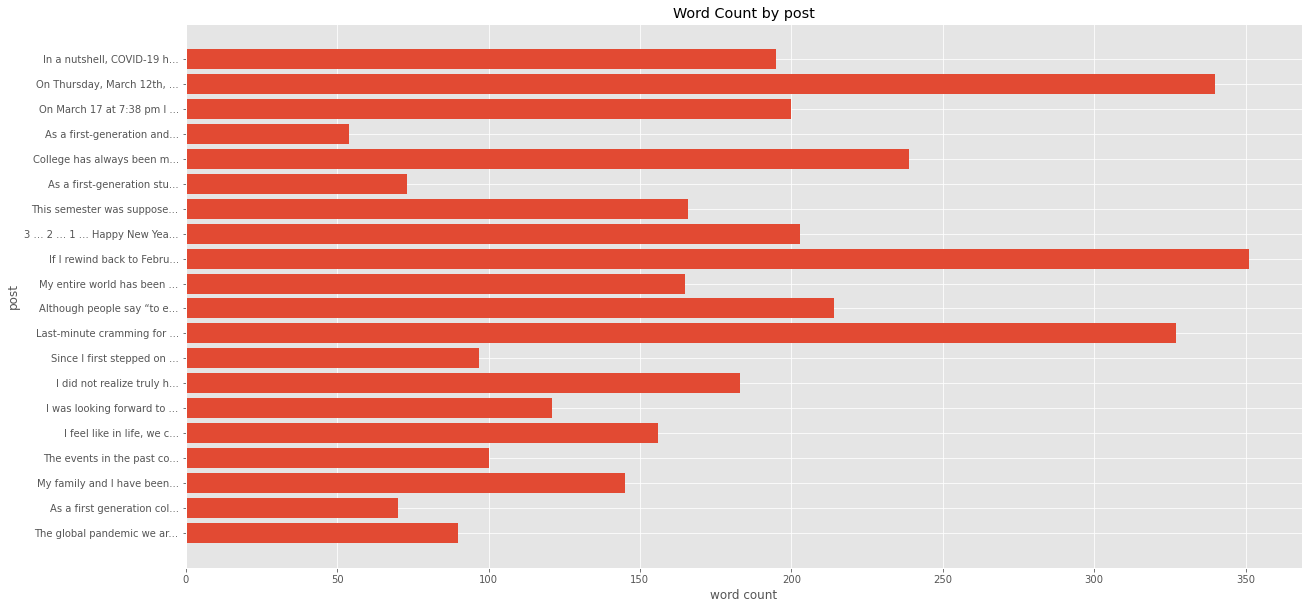

In [9]:
#word count per document in corpus
word_count = []
labels = []

for txt in token_words:
    word_count.append(len(txt))

for txt in df_label:
    if len(txt) > 50:
        txt = txt[0:25] + '...'
    labels.append(txt)

plt.figure(figsize=(20,10))
plt.title('Word Count by post')
plt.barh(labels[0:20], word_count[0:20])
plt.xlabel('word count')
plt.ylabel('post');
#plt.savefig('word_count.png', dpi=300, bbox_inches='tight');

In [10]:
# from wordcloud import WordCloud

# wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2", max_font_size=80, random_state=42,
#               min_font_size = 5).generate(str(token_txt))

# plt.figure(figsize = (8, 8), facecolor = None) 
# plt.imshow(wc) 
# plt.axis("off") 
# plt.tight_layout(pad = 0) 
  
# plt.show();

In [11]:
cv = CountVectorizer(stop_words='english')
cv_txt = cv.fit_transform(token_txt)
df_txt = pd.DataFrame(cv_txt.toarray(), index=labels, columns=cv.get_feature_names())

In [14]:
df_txt.head(5)

,aback,ability,abroad,abrupt,abruptly,absence,absolute,absolutely,abuela,abundance,...,youd,youll,young,younger,youngest,youre,youth,youtube,zip,zoom
The global pandemic we ar...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
As a first generation col...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
My family and I have been...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The events in the past co...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"I feel like in life, we c...",0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
# cv = TfidfVectorizer(stop_words="english")
# cv_txt = cv.fit_transform(token_txt).toarray()
# df_txt = pd.DataFrame(cv_txt, index=labels, columns=cv.get_feature_names())

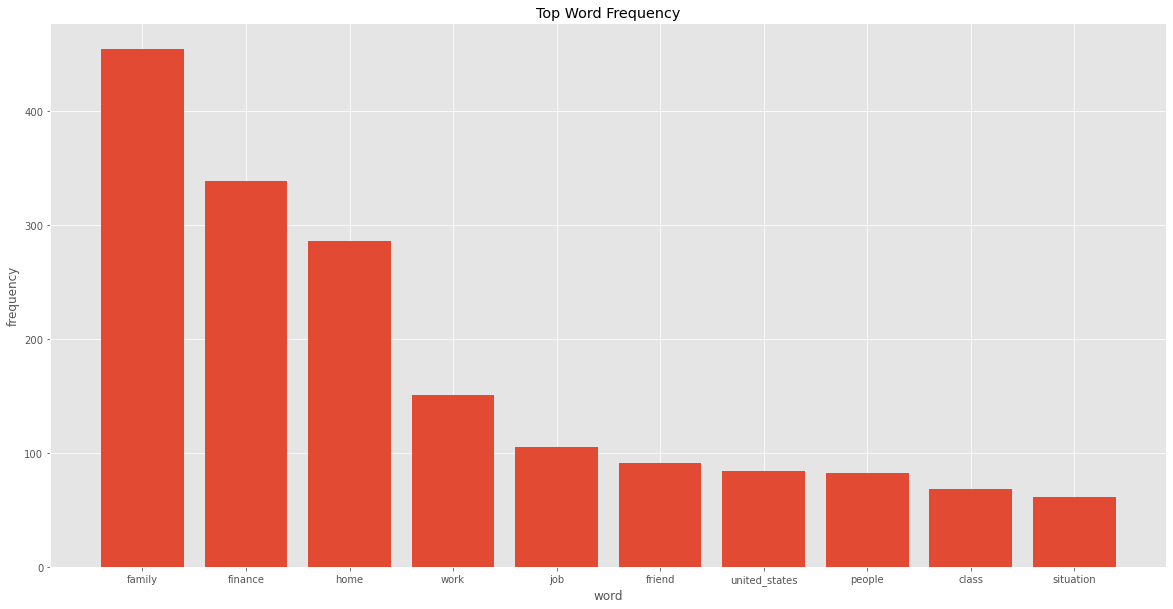

In [173]:
#frequency of top 8 words in corpus
freq = list(df_txt.sum(axis=0).sort_values(ascending=False))
col_labels = list(df_txt.sum(axis=0).sort_values(ascending=False).index)

plt.figure(figsize=(20,10))
plt.title('Top Word Frequency')
plt.bar(col_labels[0:10], freq[0:10])
plt.xlabel('word')
plt.ylabel('frequency');
#plt.savefig('word_freq.png', dpi=300, bbox_inches='tight');

In [123]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [124]:
nmf_model = NMF(4)
topic_txt = nmf_model.fit_transform(cv_txt)

topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["Personal Health","Money", "Anxiety", "Fear"],
             columns = cv.get_feature_names())

In [125]:
topic_word.sort_values(by='Personal Health', axis=1, ascending=False)

,family,home,friend,work,good,united_states,health,online,living,help,...,category,sanitizer,helplessly,article,satisfied,caution,save,saved,saving,lesson
Personal Health,5.728,4.085,1.470,0.843,0.674,0.619,0.616,0.604,0.602,0.533,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Money,0.166,1.222,0.216,0.586,0.049,0.941,0.141,0.312,0.182,0.303,...,0.172,0.000,0.000,0.000,0.085,0.000,0.176,0.013,0.071,0.009
Anxiety,3.670,0.598,0.000,1.301,0.000,0.293,0.337,0.014,0.054,0.261,...,0.000,0.094,0.094,0.000,0.000,0.094,0.092,0.093,0.135,0.002
Fear,0.935,0.645,0.000,0.951,0.025,0.146,0.000,0.078,0.280,0.060,...,0.000,0.000,0.000,0.154,0.000,0.000,0.000,0.000,0.151,0.000


In [169]:
# ph_df = pd.DataFrame(topic_word.loc['Fear'].sort_values(ascending=False))
# ph_df.to_csv('covid_Fear.csv')

In [171]:
display_topics(nmf_model, cv.get_feature_names(), 13, topic_names=["Personal Health","Money", "Anxiety", "Fear"])


Topic: ' Personal Health '
family, home, friend, work, good, united_states, health, online, living, help, world, anxiety, hope

Topic: ' Money '
finance, home, semester, united_states, spring, job, housing, travel, situation, work, leave, rest, email

Topic: ' Anxiety '
family, finance, city, work, people, new_york, crisis, home, class, job, suffering, outbreak, order

Topic: ' Fear '
face, mask, space, food, asian, people, scared, chinese, work, family, social, job, experience


In [128]:
# print(stop_words)

In [129]:
# my_dict.get('would')

In [130]:
H = pd.DataFrame(topic_txt.round(10), 
                 index = labels, 
                 columns = ["Personal Health","Money", "Anxiety", "Fear"])
H

,Personal Health,Money,Anxiety,Fear
The global pandemic we ar...,0.122351,0.100849,0.256051,0.000000
As a first generation col...,0.050510,0.046689,0.000000,0.121871
My family and I have been...,0.813297,0.287648,0.996293,0.000000
The events in the past co...,0.344106,0.465741,0.675726,0.080676
"I feel like in life, we c...",0.235388,0.307744,0.000000,0.091569
...,...,...,...,...
Anyone who knows me knows...,1.915098,0.965169,0.000000,0.000000
"This Spring, I was meant ...",0.386623,0.207954,0.000000,0.155445
"These past few weeks, my ...",1.270515,0.000000,0.657771,0.000000
I got the email from my c...,3.580012,0.000000,0.000000,0.000000


In [170]:
# H.to_csv('covid_H.csv')